In [37]:
# import necessary libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.datasets import fashion_mnist

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


In [49]:
# load dataset
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


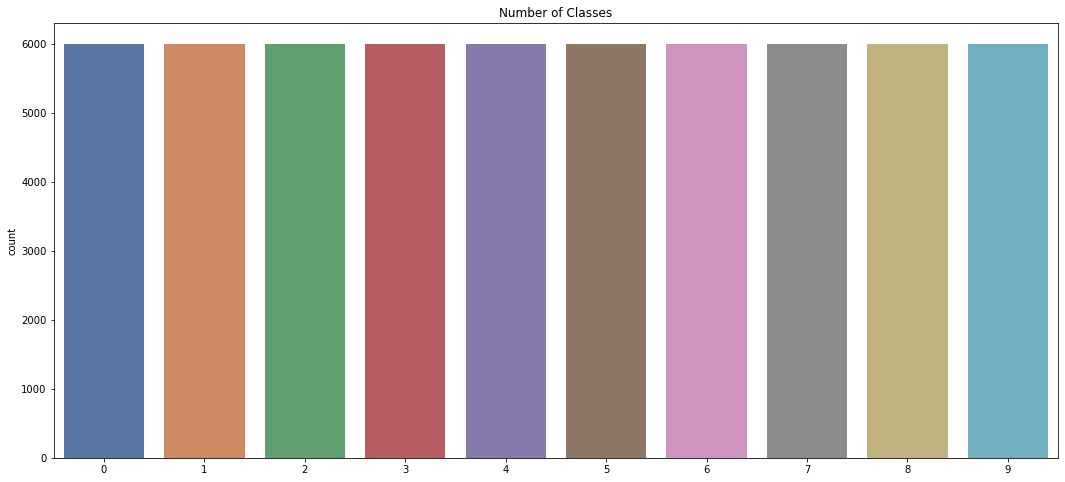

In [50]:
plt.figure(figsize=(18, 8))
sns.countplot(trainY, palette="deep")
plt.title("Number of Classes")
plt.show()

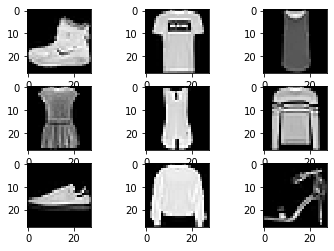

In [51]:
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

The dataset already has a well-defined train and test dataset that we can use.

In order to estimate the performance of a model for a given training run, we can further split the training set into a train and validation dataset. Performance on the train and validation dataset over each run can then be plotted to provide learning curves and insight into how well a model is learning the problem.

The Keras API supports this by specifying the “validation_data” argument to the model.fit() function when training the model, that will, in turn, return an object that describes model performance for the chosen loss and metrics on each training epoch.

In [52]:
# reshape the data arrays to have a single color channel.
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

We also know that there are 10 classes and that classes are represented as unique integers.

We can, therefore, use a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value. We can achieve this with the to_categorical() utility function.

In [53]:
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [54]:
# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# initialize the label names
labelNames = ["top", "trouser", "pullover", "dress", "coat",
    "sandal", "shirt", "sneaker", "bag", "ankle boot"]

In [6]:
# initialize the model along with the input shape to be
# "channels last" and the channels dimension itself
model = Sequential()

width = 28
height = 28
depth = 1
classes = 10
inputShape = (height, width, depth)
chanDim = -1

# first CONV => RELU => CONV => RELU => POOL layer set
model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
# second CONV => RELU => CONV => RELU => POOL layer set
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
 
# softmax classifier
model.add(Dense(classes))
model.add(Activation("softmax"))

#### Layers
Below we define our CNNmodel with the Sequential() function before defining the specific layers we will apply to our convolutional neural network.

#### Conv + Maxpool
The Convolution layer is the main process for the CNN. in this operation, there is a filter detecting edges or specific shapes, beginning in the top left of the image. The filter is multiplied with some value across the same indices, after which the results are summed and put into an output matrix. The filter then 'strides' right and repeats the process again and again. Following these operations we apply a ReLU function. The maxpooling in this later reduces the parameters needed for the computing process. Maxpooling prevents overfitting.

#### Dropout
Dropout is a regularization technique that aids in reducing overfitting by dropping out visible or hidden nodes in the neural network.

#### Flattening
Basically after applying our laters we need to flatten the matrix into a one dimensional array for use with the rest of our CNN.

#### Fully Connecting
This layer takes data from the 1D array we created with our flattening layer and begins the learning process.

In [7]:
# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 20
INIT_LR = 0.01
BS = 1024

In [8]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [9]:
# train the network
print("[INFO] training model...")
H = model.fit(trainX, trainY,
    validation_data=(testX, testY),
    batch_size=BS, epochs=NUM_EPOCHS)

[INFO] training model...
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 263s 4ms/step - loss: 0.8510 - accuracy: 0.7265 - val_loss: 2.2138 - val_accuracy: 0.2020
Epoch 2/20
60000/60000 [==============================] - 259s 4ms/step - loss: 0.4418 - accuracy: 0.8404 - val_loss: 2.3604 - val_accuracy: 0.1378
Epoch 3/20
60000/60000 [==============================] - 257s 4ms/step - loss: 0.3882 - accuracy: 0.8581 - val_loss: 2.6254 - val_accuracy: 0.1783
Epoch 4/20
60000/60000 [==============================] - 257s 4ms/step - loss: 0.3542 - accuracy: 0.8722 - val_loss: 3.1525 - val_accuracy: 0.2033
Epoch 5/20
60000/60000 [==============================] - 257s 4ms/step - loss: 0.3293 - accuracy: 0.8804 - val_loss: 2.7466 - val_accuracy: 0.3358
Epoch 6/20
60000/60000 [==============================] - 259s 4ms/step - loss: 0.3110 - accuracy: 0.8880 - val_loss: 1.7909 - val_accuracy: 0.4291
Epoch 7/20
60000/60000 [=============

In [44]:
print("Accuracy after fitting: {:.2f}%".format(H.history['accuracy'][-1]*100))

Accuracy after fitting: 91.81%


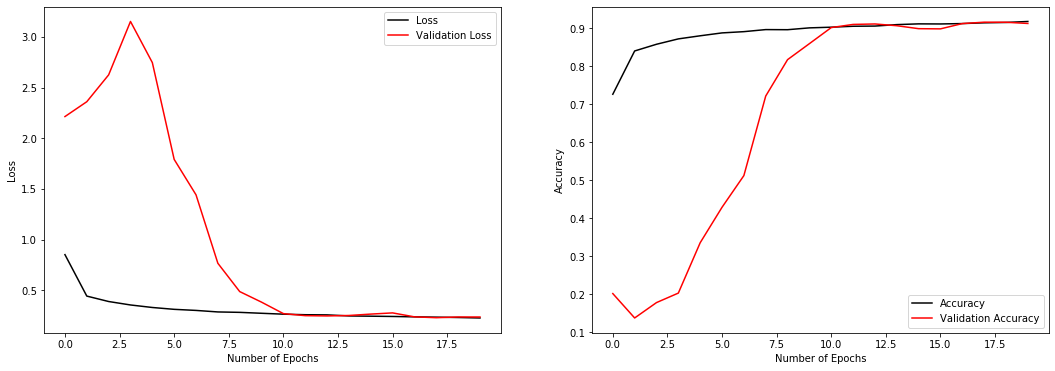

In [45]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(H.history['loss'], color="black", label = "Loss")
plt.plot(H.history['val_loss'], color="red", label = "Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(H.history['accuracy'], color="black", label = "Accuracy")
plt.plot(H.history['val_accuracy'], color="red", label = "Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.legend()
plt.show()

In [55]:
print(testX.shape)
print(testY.shape)

(10000, 28, 28, 1)
(10000, 10)


In [56]:
# With our model trained up, lets find out how accurate it is by passing it the test data from earlier
score = model.evaluate(testX, testY, verbose=0)
print("Test Accuracy: {:.2f}%".format(score[1]*100))
print("Test Loss: {:.3f}".format(score[0]))

Test Accuracy: 91.28%
Test Loss: 0.235


#### Plot Confusion Matrix
Confusion matrix will allow us to visualize our algorithms performance, plotting the correct answers against the answers our model has estimated. With it, we will be able to see which 'classes' of clothing items are least accurately predicted by our model. (We could then pass additional items of that class in order to strengthen our machines predictive capabilities)

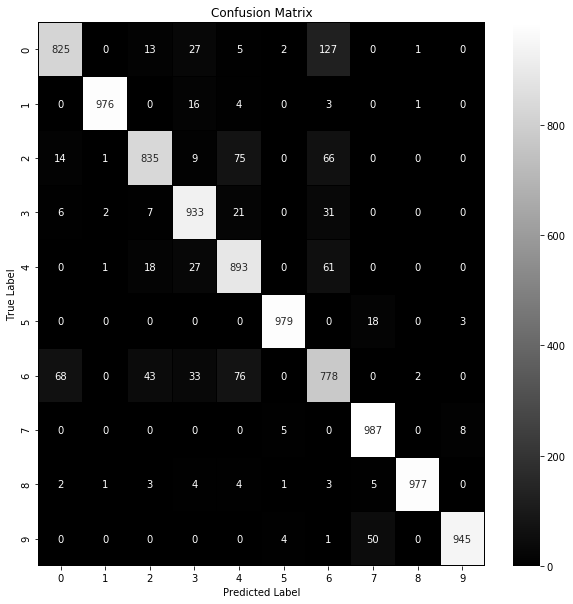

Class: 0
Number of Wrong Prediction: 175 out of 1000
Class: 1
Number of Wrong Prediction: 24 out of 1000
Class: 2
Number of Wrong Prediction: 165 out of 1000
Class: 3
Number of Wrong Prediction: 67 out of 1000
Class: 4
Number of Wrong Prediction: 107 out of 1000
Class: 5
Number of Wrong Prediction: 21 out of 1000
Class: 6
Number of Wrong Prediction: 222 out of 1000
Class: 7
Number of Wrong Prediction: 13 out of 1000
Class: 8
Number of Wrong Prediction: 23 out of 1000
Class: 9
Number of Wrong Prediction: 55 out of 1000


In [57]:
Y_pred = model.predict(testX)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(testY, axis = 1)
confusionMatrix = confusion_matrix(Y_true, Y_pred_classes)

f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(confusionMatrix, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# For loop to print how many items of each class have been incorrectly estimated
for i in range(len(confusionMatrix)):
    print("Class:",str(i))
    print("Number of Wrong Prediction:", str(sum(confusionMatrix[i])-confusionMatrix[i][i]), "out of 1000")